In [23]:
import pandas as pd
import numpy as np
import glob
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Read the integrated dataset
integrated_df = pd.read_csv("outputs/integrated_ocean_plastics.csv")

In [24]:
# Display the first few rows of the integrated dataset
integrated_df.head()

,sample_id,Continent,Country,System,Waterbody,Zone Area,Tidal_Zone,Test_Area,Year,Date,mp/kg dw,Size_class,Dominant_Size,dominant_color,source,environment_type,location,concentration_level
0,DOER_97,Africa,Tunisia,Estuarine,Lagoon of Bizerte,Coastal,Subtidal,Menzel Jemil,2016.0,unknown,3682.0,microplastics,<2 mm,unknown,DOER Database,Estuary,"Menzel Jemil, Tunisia",High
1,DOER_98,Africa,Tunisia,Estuarine,Lagoon of Bizerte,Coastal,Subtidal,Carrier Bay,2016.0,unknown,6628.0,microplastics,<2 mm,unknown,DOER Database,Estuary,"Carrier Bay, Tunisia",High
2,DOER_96,Africa,Tunisia,Estuarine,Lagoon of Bizerte,Coastal,Subtidal,Menzel Abderrahmane,2016.0,unknown,17921.0,microplastics,<2 mm,unknown,DOER Database,Estuary,"Menzel Abderrahmane, Tunisia",Very High
3,DOER_99,Africa,Tunisia,Estuarine,Lagoon of Bizerte,Coastal,Subtidal,Channel,2016.0,unknown,3191.0,microplastics,<2 mm,unknown,DOER Database,Estuary,"Channel, Tunisia",High
4,DOER_1218,Africa,South Africa,Estuarine,Durban Bay,Coastal,Harbor/Port,Port of Durban,2019.0,unknown,28400.0,unknown,(N/R),unknown,DOER Database,Estuary,"Port of Durban, South Africa",Very High


In [25]:
# Check current color distribution in the integrated dataset
print("Current color values in the integrated dataset:")
print(integrated_df['dominant_color'].value_counts())

Current color values in the integrated dataset:
dominant_color
unknown    2704
Name: count, dtype: int64


# Creating a Color Category Column Based on Taiwan Beach Dataset

This notebook processes the color columns in the Taiwan beach datasets to create a more detailed categorical color variable that will replace the existing 'dominant_color' column in the integrated dataset.

In [26]:
/# Get all color count CSV files
color_files = glob.glob("data/*color count.csv")
print(f"Found {len(color_files)} color count files: {color_files}")

Found 2 color count files: ['data/Xialiao Beach color count.csv', 'data/Longmen Beach color count.csv']


In [27]:
# Load the first file to see its structure
sample_df = pd.read_csv(color_files[0])
print(f"Columns in the color count files:")
print(sample_df.columns.tolist())

Columns in the color count files:
['Date_YYYY-MM-DD', 'Country_Region', 'Location_name', 'Location_lat', 'Location_lon', 'Transect', 'Position', 'Size_min_mm', 'Size_max_mm', 'Size_class', 'no_color', 'black', 'grey', 'red_pink', 'orange_brown_yellow', 'green', 'blue', 'purple']


In [28]:
# Identify the color columns
color_columns = [col for col in sample_df.columns if col not in 
               ['Date_YYYY-MM-DD', 'Country_Region', 'Location_name', 
                'Location_lat', 'Location_lon', 'Transect', 'Position', 
                'Size_min_mm', 'Size_max_mm', 'Size_class']]

print(f"Identified color columns: {color_columns}")

Identified color columns: ['no_color', 'black', 'grey', 'red_pink', 'orange_brown_yellow', 'green', 'blue', 'purple']


## Load and combine all color count data

In [29]:
# Load and combine all color count data
color_dfs = []
for file_path in color_files:
    beach_name = Path(file_path).stem.split(' ')[0]  # Extract beach name from filename
    df = pd.read_csv(file_path)
    df['Beach'] = beach_name
    color_dfs.append(df)

combined_color_df = pd.concat(color_dfs, ignore_index=True)
print(f"Combined dataset shape: {combined_color_df.shape}")

Combined dataset shape: (2592, 19)


In [30]:
# Create a unique sample identifier
combined_color_df['sample_id'] = (
    combined_color_df['Beach'] + '_' + 
    combined_color_df['Date_YYYY-MM-DD'] + '_' + 
    combined_color_df['Transect'] + '_' + 
    combined_color_df['Position'].astype(str) + '_' + 
    combined_color_df['Size_class']
)

print(f"Number of unique samples: {combined_color_df['sample_id'].nunique()}")

Number of unique samples: 2592


## Determine the dominant color for each sample

In [31]:
# Function to determine the dominant color
def get_dominant_color(row, color_columns):
    # Convert any missing values to 0
    for col in color_columns:
        if pd.isna(row[col]):
            row[col] = 0
            
    # Find the color with the highest count
    max_value = 0
    dominant_color = 'unknown'
    
    for col in color_columns:
        if row[col] > max_value:
            max_value = row[col]
            dominant_color = col
    
    # If all values are 0, set to 'unknown'
    if max_value == 0:
        return 'unknown'
    
    return dominant_color

# Apply the function to determine the dominant color for each sample
combined_color_df['color_category'] = combined_color_df.apply(
    lambda row: get_dominant_color(row, color_columns), axis=1
)

In [32]:
# Count the occurrences of each dominant color
color_counts = combined_color_df['color_category'].value_counts()
print("Distribution of dominant colors:")
print(color_counts)

Distribution of dominant colors:
color_category
no_color               1831
unknown                 652
black                    26
green                    22
grey                     18
orange_brown_yellow      15
red_pink                 14
blue                     13
purple                    1
Name: count, dtype: int64


## Create standardized color category names

In [33]:
# Create a mapping for nicer color names
color_mapping = {
    'no_color': 'Transparent/Clear',
    'black': 'Black',
    'grey': 'Grey',
    'red_pink': 'Red/Pink',
    'orange_brown_yellow': 'Orange/Brown/Yellow',
    'green': 'Green',
    'blue': 'Blue',
    'purple': 'Purple',
    'unknown': 'Unknown'
}

# Apply the mapping to create a standardized color category
combined_color_df['color_display'] = combined_color_df['color_category'].map(color_mapping)

In [34]:
# Examine the distribution of standardized color categories
display_counts = combined_color_df['color_display'].value_counts()
print("Distribution of standardized color categories:")
print(display_counts)

Distribution of standardized color categories:
color_display
Transparent/Clear      1831
Unknown                 652
Black                    26
Green                    22
Grey                     18
Orange/Brown/Yellow      15
Red/Pink                 14
Blue                     13
Purple                    1
Name: count, dtype: int64


## Visualize the distribution of colors

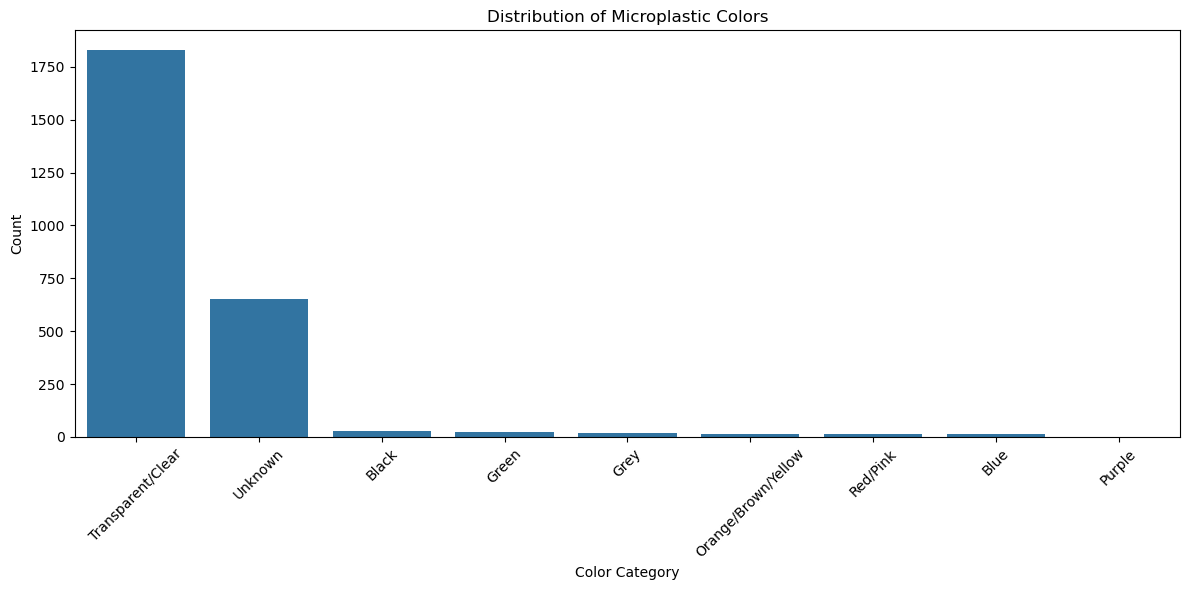

In [35]:
# Plot the distribution of color categories
plt.figure(figsize=(12, 6))
sns.countplot(data=combined_color_df, x='color_display', order=display_counts.index)
plt.title('Distribution of Microplastic Colors')
plt.xlabel('Color Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Merge the color data with the integrated dataset

In [36]:
# Create a minimal dataset with sample_id and color information for merging
color_info = combined_color_df[['sample_id', 'color_category', 'color_display']]

# Display a sample of the color info
color_info.head()

,sample_id,color_category,color_display
0,Xialiao_2018-04-25_A_1_microplastics,no_color,Transparent/Clear
1,Xialiao_2018-04-25_A_2_microplastics,no_color,Transparent/Clear
2,Xialiao_2018-04-25_A_3_microplastics,no_color,Transparent/Clear
3,Xialiao_2018-04-25_A_4_microplastics,no_color,Transparent/Clear
4,Xialiao_2018-04-25_A_5_microplastics,no_color,Transparent/Clear


# Merge the color information with the integrated dataset
merged_df = integrated_df.merge(color_info, on='sample_id', how='left')

# Check how many samples were matched
matched_count = merged_df['color_category'].notna().sum()
total_count = len(merged_df)
match_percentage = (matched_count / total_count) * 100

print(f"Matched {matched_count} out of {total_count} samples ({match_percentage:.2f}%)")

# Check the first few rows of the merged dataset
merged_df.head()
## Update the color information in the integrated dataset

In [38]:
# Update the dominant_color column in the integrated dataset
# For samples that have new color information, use the color_category,
# For unmatched samples, keep the existing dominant_color value
merged_df['dominant_color'] = merged_df.apply(
    lambda row: row['color_category'] if pd.notna(row['color_category']) else row['dominant_color'],
    axis=1
)

# Add a new column for the display-friendly color name
merged_df['color_display'] = merged_df.apply(
    lambda row: row['color_display'] if pd.notna(row['color_display']) else row['dominant_color'],
    axis=1
)

# Drop the intermediate color_category column
merged_df = merged_df.drop(columns=['color_category'])

# Check the updated distribution of colors
print("Updated distribution of colors:")
print(merged_df['dominant_color'].value_counts())

Updated distribution of colors:
dominant_color
unknown    2704
Name: count, dtype: int64


## Analyze color distribution by other variables

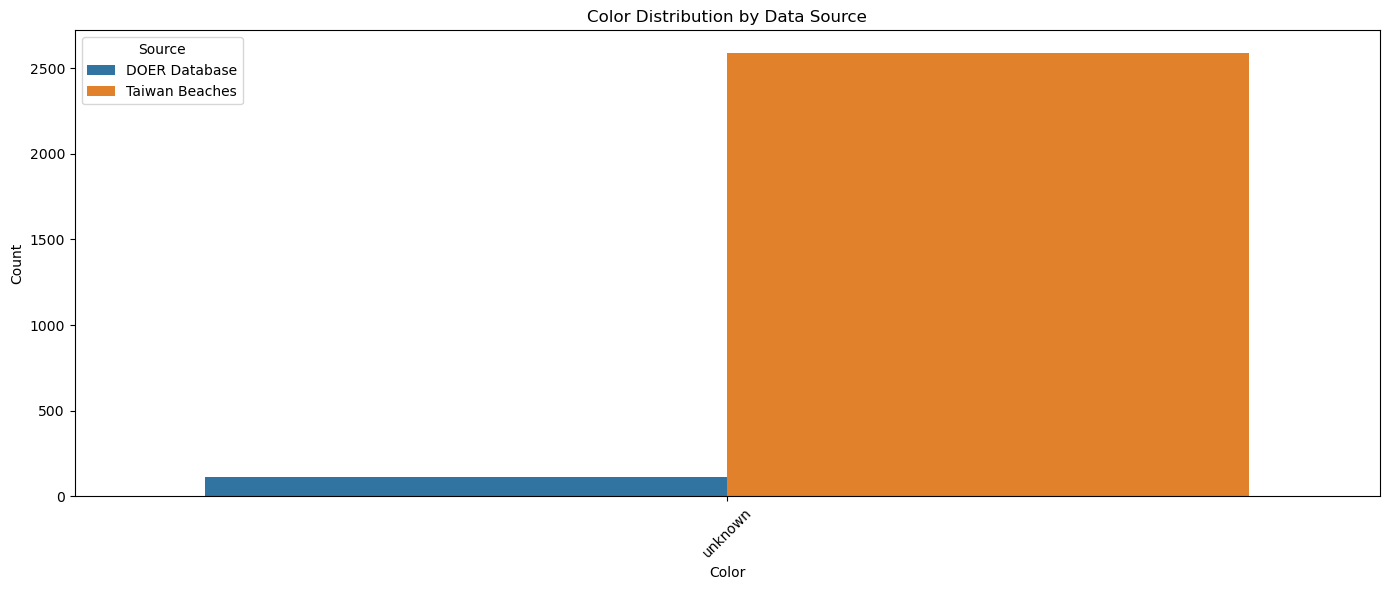

In [39]:
# Distribution by source
plt.figure(figsize=(14, 6))
sns.countplot(data=merged_df, x='dominant_color', hue='source')
plt.title('Color Distribution by Data Source')
plt.xlabel('Color')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Source')
plt.tight_layout()
plt.show()

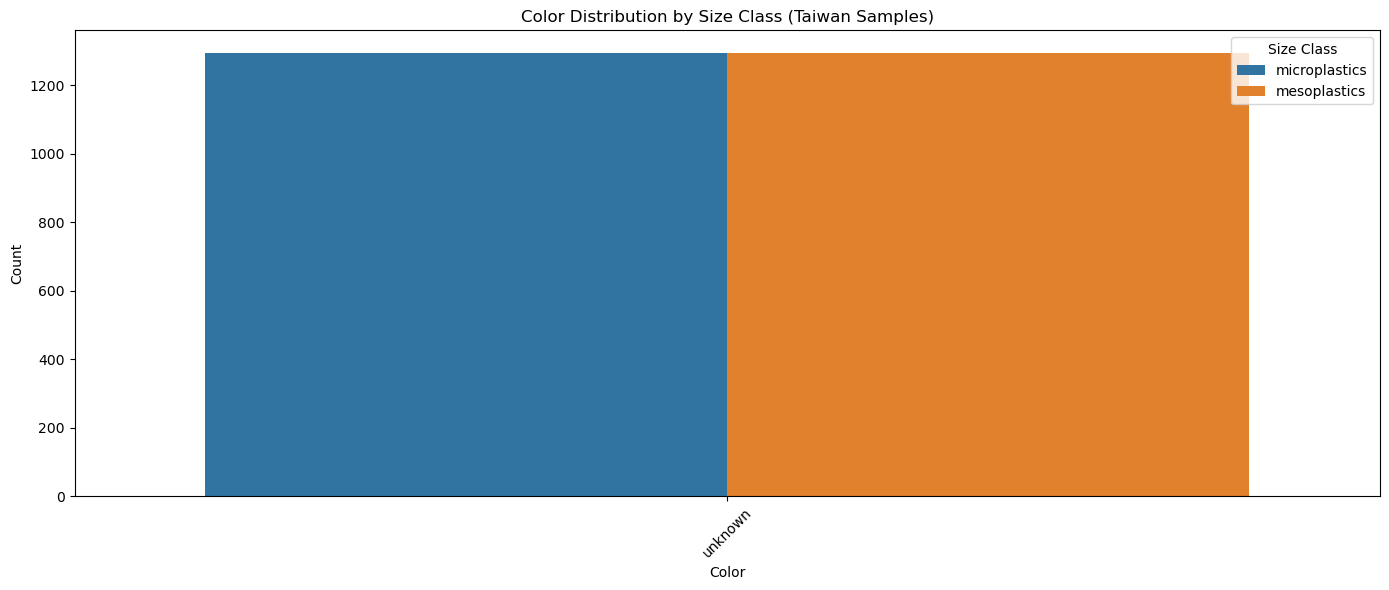

In [40]:
# Distribution by size class (for Taiwan samples only)
taiwan_samples = merged_df[merged_df['source'] == 'Taiwan Beaches']
plt.figure(figsize=(14, 6))
sns.countplot(data=taiwan_samples, x='dominant_color', hue='Size_class')
plt.title('Color Distribution by Size Class (Taiwan Samples)')
plt.xlabel('Color')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Size Class')
plt.tight_layout()
plt.show()

## Save the updated integrated dataset

In [41]:
# Save the updated integrated dataset
output_file = 'outputs/integrated_ocean_plastics_updated.csv'
merged_df.to_csv(output_file, index=False)
print(f"Updated integrated dataset saved to {output_file}")

Updated integrated dataset saved to outputs/integrated_ocean_plastics_updated.csv


## Summary of Changes

In this notebook, we have:

1. Loaded and examined color count data from the Taiwan beach datasets
2. Determined the dominant color for each sample based on the highest count
3. Created standardized color category names for better readability
4. Merged the color information with the integrated dataset
5. Updated the dominant_color column and added a new color_display column
6. Analyzed the color distribution by data source and size class
7. Saved the updated integrated dataset with enhanced color information

This improved color categorization will be useful for future analyses and visualizations of the microplastics data.